# IRWA Project: G102_9

### Uzair Ramzan Parveen - U199323
### Marc Riera Arza - U199905
### Payden Reed Knettles - U250322

##  Imports

In [1]:

import wordcloud
from wordcloud import WordCloud
import json
from collections import defaultdict
from array import array
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
import time
import itertools
import heapq
from sklearn.manifold import TSNE
from gensim.models import Word2Vec



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IRWA Project part 1


In this section we have the Data preprocessing and the exploratory analysis to get to know the data before working with it.

### Data Loading


In this section, we have the code that carries out the loading of the input data.

In [3]:
# Data loading

file_path = '/content/drive/MyDrive/IRWA_G102_9/Part1/data/farmers-protest-tweets.json'    # Check path

tweets_data = []
with open(file_path, 'r') as file:
    for line in file:
        try:
            tweet = json.loads(line)  # Load each line as a separate JSON object
            tweets_data.append(tweet)  # Append to the list
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")


### Data Preprocessing

In this section, we have the code for the function that we will use to preprocess our input data to remove extra data and only keep the desired fields.

#### Preprocessing function

In [4]:
# Initializing stemmer

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def line_processor(tweet_data):

    # Extract key fields from the tweet data
    tweet_content = tweet_data.get("content", "")
    tweet_date = tweet_data.get("date", "")
    tweet_url = tweet_data.get("url", "")
    tweet_likes = tweet_data.get("likeCount", 0)
    tweet_retweets = tweet_data.get("retweetCount", 0)
    tweet_id = tweet_data.get("id", "")

    # Split tweet content to extract hashtags
    basic_split = tweet_content.split()
    hashtags = [word for word in basic_split if word.startswith("#")]
    non_hashtag_words = [word for word in basic_split if not word.startswith("#")]

    # Tokenization: word separation
    tokens = word_tokenize(' '.join(non_hashtag_words))

    # Cleaning: Remove stopwords, punctuation, non-alphanumeric, URLs, hashtags, and stemming
    relevant_tokens = [
        stemmer.stem(token.lower()) for token in tokens
        if token.isalnum() and not token.startswith(("http", "www"))
        and token.lower() not in stop_words and len(token) > 2
    ]

    # Rebuild the cleaned tweet content
    cleaned_tweet = ' '.join(relevant_tokens)

    # Return the processed data
    return {
        "Content": cleaned_tweet,
        "Date": tweet_date,
        "Likes": tweet_likes,
        "Retweets": tweet_retweets,
        "URL": tweet_url,
        "Hashtags":hashtags,
        "ID": tweet_id
    }



In [5]:
# Example of usage with tweet data

processed_tweet = line_processor(tweets_data[0])
print(processed_tweet)

{'Content': 'world progress indian polic govt still tri take india back horrif past tyranni narendramodi delhipolic shame', 'Date': '2021-02-24T09:23:35+00:00', 'Likes': 0, 'Retweets': 0, 'URL': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198', 'Hashtags': ['#ModiDontSellFarmers', '#FarmersProtest', '#FreeNodeepKaur'], 'ID': 1364506249291784198}


#### Preprocessing tweets

In this section, we are applying the processing function implemented previously to process our data and converting it to a dataframe with the desired fields as columns and the tweet ID as index.

In [6]:
# List to store processed tweet data
processed_data = []

# Process each tweet and append the result to the list
for tweet in tweets_data:
    data = line_processor(tweet)
    processed_data.append(data)

# Create DataFrame from the list in one go
tweets_df = pd.DataFrame(processed_data)

# Set the 'ID' column as the index
tweets_df.set_index("ID", inplace=True)

# Limiting the Date column to date only
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])
tweets_df['Date'] = tweets_df['Date'].dt.date

In [7]:
# Presentation of the processed data in a dataframe
tweets_df.head(4)


,Content,Date,Likes,Retweets,URL,Hashtags
ID,,,,,,
1364506249291784198,world progress indian polic govt still tri tak...,2021-02-24,0,0,https://twitter.com/ArjunSinghPanam/status/136...,"[#ModiDontSellFarmers, #FarmersProtest, #FreeN..."
1364506237451313155,kisanektamorcha farmer constantli distroy crop...,2021-02-24,0,0,https://twitter.com/PrdeepNain/status/13645062...,"[#FarmersProtest, #ModiIgnoringFarmersDeaths, ..."
1364506195453767680,,2021-02-24,0,0,https://twitter.com/parmarmaninder/status/1364...,[#FarmersProtest]
1364506167226032128,reallyswara watch full video,2021-02-24,0,0,https://twitter.com/anmoldhaliwal/status/13645...,"[#farmersprotest, #NoFarmersNoFood]"


### Exploratory Data Analysis

In this section, we will carry out multiple tasks in order to understand our data and to have some visual support for the decisions to be made later on.

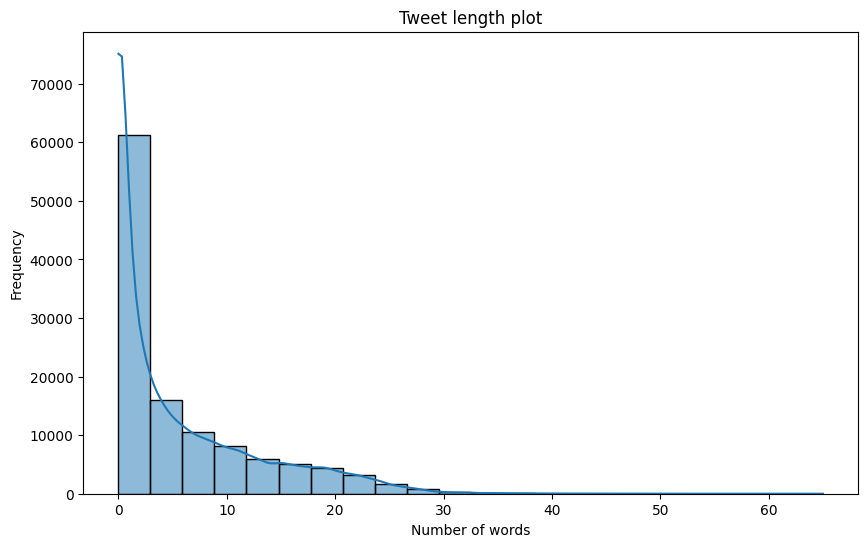

In [8]:
# Tweet length plot

# Aux column for the length of each
vocab_df = tweets_df.copy()
vocab_df['Wordcount'] = tweets_df['Content'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(vocab_df['Wordcount'], bins=22, kde=True)

plt.title('Tweet length plot')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

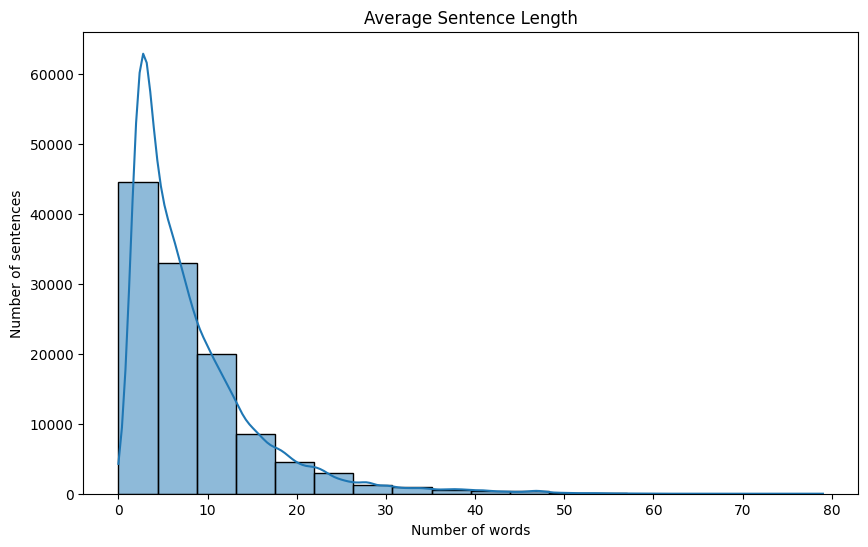

In [9]:
# Average sentence length plot

# Getting raw tweet content
raw_content = [tweet['content'] for tweet in tweets_data]

# Function to calculate average sentence length in a tweet
def avg_SL(tc):
  sents = sent_tokenize(tc)
  num_sents = len(sents)
  words = word_tokenize(tc)
  num_words = sum(1 for word in words if word.isalnum())
  return num_words/num_sents if num_sents > 0 else 0

avg_lengths = [avg_SL(content) for content in raw_content]

plt.figure(figsize=(10,6))
sns.histplot(avg_lengths, bins=18, kde=True)
plt.title('Average Sentence Length')
plt.xlabel('Number of words')
plt.ylabel('Number of sentences')
plt.show()

In [10]:
# Getting info. about our vocabulary

# Getting all the tweets' content in a single list of words
whole_content = tweets_df['Content'].str.split().explode().tolist()

# Counting appearances
word_counts = Counter(whole_content)

# Converting to dict
vocab_dict = dict(word_counts)
print('Tweet vocabulary size is', len(vocab_dict))

# Sorting dictionary items to get the top 5 appearing words
sorted_dict = sorted(vocab_dict.items(), key=lambda x: x[1],  reverse=True)
print('\nThe top 5 most appearing words are:')
for item in sorted_dict[:5]:
  print(item)


Tweet vocabulary size is 80318

The top 5 most appearing words are:
('farmer', 17018)
('india', 6861)
('support', 6704)
('amp', 4994)
('protest', 4990)


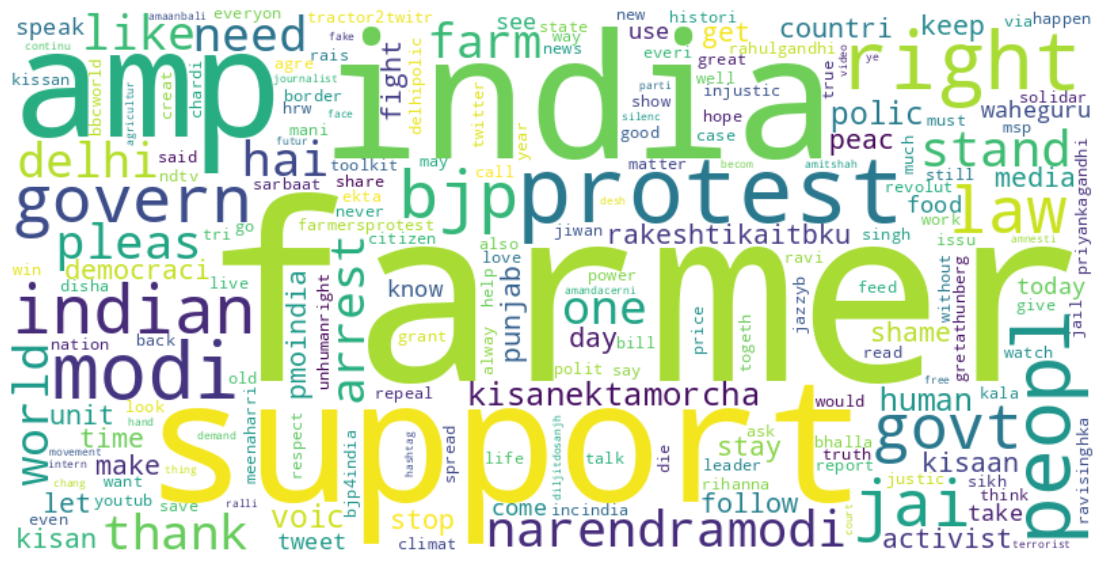

In [11]:
# Generating a word cloud
words_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocab_dict)

plt.figure(figsize=(14,8))
plt.imshow(words_wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [12]:
# Creating a new dataframe sorted by the number of retweets
rts_df = tweets_df.copy()
rts_sorted = rts_df.sort_values(by='Retweets', ascending=False)
print('The following are the Top 5 Most Retweeted Tweets:')
rts_sorted.reset_index().drop(columns=['ID', 'URL']).head(5)

The following are the Top 5 Most Retweeted Tweets:


,Content,Date,Likes,Retweets,Hashtags
0,200,2021-02-12,25824,7723,"[#FarmLaws, #FarmersProtest, #किसान_एकता_जिंदा..."
1,happen germani german govt block path barb wir...,2021-02-23,27888,6164,[#FarmersProtest]
2,disha ravi climat activist arrest delhi polic ...,2021-02-14,8974,4673,"[#farmersprotest., #freedisharavi]"
3,disha ravi broke court room told judg mere edi...,2021-02-14,10403,3742,[#FarmersProtest]
4,farmer sweet see amandacerni rihanna,2021-02-12,17325,3332,"[#FarmersProtest, #ModiWhereAreMissingFarmers,..."


In [13]:
# Extracting the preprocessed data
tweets_df.to_csv('/content/drive/MyDrive/IRWA_G102_9/Part2/data/preprocessed_data.csv')

## IRWA Project part 2

In this section we have the indexing and the evaluation for our data.

In [14]:
# Reading relevant data

preproc_df = pd.read_csv('/content/drive/MyDrive/IRWA_G102_9/Part2/data/preprocessed_data.csv')
english_ids = pd.read_csv('/content/drive/MyDrive/IRWA_G102_9/Part2/data/tweet_document_ids_map.csv')

### Dataset filtering

In [15]:
# Keeping only the tweets that are mostly in English

whole_df = preproc_df.copy()
df_filter = english_ids.copy()

filtered_tw = pd.merge(whole_df, df_filter, left_on='ID', right_on='id', how='inner')

print('We have reduced our dataset from', whole_df.shape[0], 'tweets to', filtered_tw.shape[0], 'tweets.')

We have reduced our dataset from 117407 tweets to 48429 tweets.


### Index creation

In [16]:
# Function to create an index

def create_index(tw_df):
  index = defaultdict(list)  # Main index structure

  # Iterate through rows of the dataframe
  for _, row in tw_df.iterrows():

    content = row['Content']

    if isinstance(content, str):  # Only splitting if content is a string
        terms = content.split()
    else:
        terms = []  # Handling NaN content as an empty list

    current_tweet_index = defaultdict(lambda: [row['ID'], array('I')])  # Initialize tweet-specific index

    # Process each term and its position
    for position, term in enumerate(terms):
      current_tweet_index[term][1].append(position)

    # Merge the current tweet index with the main index
    for word, info in current_tweet_index.items():
      index[word].append(info)

  return index


In [17]:
# Benchmarking

start_time = time.time()
num_tweets = len(filtered_tw)
inv_index = create_index(filtered_tw)
print("Total time to create the TD-IDF index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the TD-IDF index: 8.4 seconds


In [18]:
# Uncomment and run the following line to view the created index
#inv_index['progress']

### TF-IDF Index

In [19]:
# TF-IDF index

def create_index_tfidf(tweets_df, num_tweets):

  index = defaultdict(list)
  tf = defaultdict(list)  # term frequencies of terms in tweets
  df = defaultdict(int)   # tweet frequencies of terms in the corpus
  idf = defaultdict(float)

  for idx, row in tweets_df.iterrows():

    content = row['Content']

    if isinstance(content, str):  # Only splitting if content is a string
      terms = content.split()
    else:
      terms = []  # Handling NaN content as an empty list

    current_tweet_index = defaultdict(lambda: [idx, array('I')])  # Initialize tweet-specific index

    # Process each term and its position
    for position, term in enumerate(terms):
      current_tweet_index[term][1].append(position)

    # Normalizing term frequencies
    norm = math.sqrt(sum(len(info[1]) ** 2 for info in current_tweet_index.values()))  # Direct norm calculation

    # Calculating the tf(dividing the term frequency by the above computed norm) and df weights
    for term, info in current_tweet_index.items():
      # Appending the tf for current term (tf = term frequency in current doc/norm)
      tf[term].append(np.round((len(info[1])) / norm, 4))
      # Incrementing the document frequency of current term (number of documents containing the current term)
      df[term] += 1 # increment DF for current term

    # Merge the current tweet index with the main index
    for term, info in current_tweet_index.items():
      index[term].append(info)

  # Computing IDF
  log_num_tweets = math.log(float(num_tweets))  # Precomputing log(num_tweets)
  for term, doc_freq in df.items():
    idf[term] = np.round(log_num_tweets - math.log(doc_freq), 4)  # Calculate and round idf in one line

  return index, tf, df, idf


In [20]:
# Benchmarking

start_time = time.time()
num_tweets = len(filtered_tw)
index, tf, df, idf = create_index_tfidf(filtered_tw, num_tweets)
print("Total time to create the TD-IDF index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the TD-IDF index: 12.22 seconds


### Query suggestions

Following are the 5 queries that will be used to evaluate our search engine:


*   Are the farmers being supported by the government?
*   What is the reason farmers are protesting?
*   Are all protesting farmers indian?
*   What do farmers stand for?
*   What are farmers rights?



In [21]:
# # Getting top n terms using TF-IDF (Code used to demonstrate the problems faced during the project)

# # Calculating TF-IDF

# tfidf = {}
# top = 7

# for term, freqs in tf.items():
#   idf_score = idf[term]
#   tfidf_scores = [freq * idf_score for freq in freqs]
#   tfidf[term] = tfidf_scores

# # Function to get the top n terms based on TF-IDF scores

# def get_top_terms(tfidf, n):
#   top_n = sorted(tfidf.items(), key = lambda x: x[1], reverse=True)[:n]
#   return [t for t,s in top_n]


# terms_for_query = get_top_terms(tfidf, top)
# print(terms_for_query)

In [22]:
# Getting top n co-occurring terms using TF

# Calculating raw co-occurrence counts across all tweets
def get_cooccurrence_counts(df, column='Content'):
    cooccurrence_counts = defaultdict(int)

    for content in df[column]:

        # Split content into terms and convert to set to avoid duplicates
        if isinstance(content, str):  # Only splitting if content is a string
          terms = set(content.split())
        else:
          terms = set()  # Handling NaN content as an empty set

        # Creating unique pairs of terms in this tweet
        for term1, term2 in itertools.combinations(terms, 2):
            # Sort term pair to keep (term1, term2) and (term2, term1) identical
            pair = tuple(sorted([term1, term2]))
            cooccurrence_counts[pair] += 1

    return cooccurrence_counts


# Weighing the co-occurrences using TF
def get_top_n_cooccurrences(cooccurrence_counts, tf, n):
    # Min-heap to maintain the top n co-occurrences
    top_cooccurrences = []

    for pair, count in cooccurrence_counts.items():
        # Get term frequencies for each term in the pair
        tf1 = sum(tf.get(pair[0], [0]))
        tf2 = sum(tf.get(pair[1], [0]))

        # Calculate the total weight
        total_weight = tf1 + tf2

        # Only consider pairs with a non-zero total weight
        if total_weight > 0:
            weighted_score = count * total_weight

            # Use a min-heap to keep the top n co-occurrences
            if len(top_cooccurrences) < n:
                heapq.heappush(top_cooccurrences, (weighted_score, pair))
            else:
                heapq.heappushpop(top_cooccurrences, (weighted_score, pair))

    # Sort the heap in descending order to get top n pairs
    top_cooccurrences.sort(reverse=True, key=lambda x: x[0])
    return [(pair, score) for score, pair in top_cooccurrences]


In [23]:
# Getting the top co-occurring terms to perform queries
top = 7
cooccurrence_counts = get_cooccurrence_counts(filtered_tw)

# Choose "tf" or "df" for weighting
top_cooccurrences = get_top_n_cooccurrences(cooccurrence_counts, tf, 7)

print("Following are the recommended co-occurring terms to perform queries:\n")
for pair, score in top_cooccurrences:
  print(f"{pair}")


Following are the recommended co-occurring terms to perform queries:

('farmer', 'support')
('farmer', 'protest')
('farmer', 'india')
('farmer', 'indian')
('amp', 'farmer')
('farmer', 'stand')
('farmer', 'right')


### Ranking

In [24]:
# Auxiliary functions

# Function to preprecess the query
def query_normalizer(line):

  #tokenise
  tokens = word_tokenize(line)

  stop_words = set(stopwords.words("english"))
  stemmer = PorterStemmer()
  # Cleaning: Remove stopwords, punctuation, non-alphanumeric, URLs, hashtags, and stemming
  relevant_tokens = [
        stemmer.stem(token.lower()) for token in tokens
        if token.isalnum() and not token.startswith(("http", "www"))
        and token.lower() not in stop_words and len(token) > 2
    ]

  return relevant_tokens


In [25]:
# Search function to get all the documents that satisfy the information needs

def search_tf_idf(query, index):
  query = query_normalizer(query)
  docs = None
  # print('Normalized query:', query)
  for term in query:
    try:
      # store in term_docs the ids of the docs that contain "term"
      term_docs = {posting[0] for posting in index[term]}

      # Initializing with the documents for the first term and intersection with the rest
      docs = term_docs if docs is None else docs & term_docs
    except:
      # If any term is not in the index, returning an empty list immediately since no doc can contain all terms
      return []

  docs = list(docs) if docs else []
  #print(len(docs))

  # Ranking the documents that contain all terms in the query
  ranked_docs = rank_documents(query, docs, index, idf, tf)
  return ranked_docs

In [26]:
# Ranking function

def rank_documents(terms, docs, index, idf, tf):  # docs are tweets in our case

  # Declaring dictionary with key-value pair (k,[0]*len(terms))
  doc_vectors = defaultdict(lambda: [0] * len(terms))
  query_vector = [0] * len(terms)

  # computing the norm for the query tf
  query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query in a dictionary
  query_norm = la.norm(list(query_terms_count.values()))

  for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
    # if term not in index:       # already checked in search function
    #   continue

    ## Compute tf*idf (normalize TF as done with documents) for the terms in query
    query_vector[termIndex] = (query_terms_count[term] / query_norm) * idf[term]

    # Generate doc_vectors for matching docs
    for doc_index, (doc, postings) in enumerate(index[term]):
      if doc in docs:
        doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]

  # Calculating the score of each doc
  # Computing the cosine similarity between queyVector and each docVector (using np.dot)
  doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
  doc_scores.sort(reverse=True)
  # print(doc_scores)
  result_docs = [x[1] for x in doc_scores]

  if len(result_docs) == 0:
      print("No results found, try again")
      #query = input()
      #docs = search_tf_idf(query, index)
  #print ('\n'.join(result_docs), '\n')
  return result_docs

In [27]:
# Querying

top = 10

print("Insert your query:")
query = "what are the people's rights?"
print(query)
# print('\n')
ranked_docs = search_tf_idf(query, index)
# print(ranked_docs[:10])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(len(ranked_docs) if top>len(ranked_docs) else top, len(ranked_docs)))
for d_idx in ranked_docs[:top]:
  print('Tweet ID: ', filtered_tw.loc[d_idx]['ID'], '   Content: ', filtered_tw.loc[d_idx]['Content'])

Insert your query:
what are the people's rights?

Top 10 results out of 287 for the searched query:

Tweet ID:  1360339591039832064    Content:  peopl right protest peac
Tweet ID:  1363197536991911938    Content:  stand right peopl late
Tweet ID:  1360147350186991616    Content:  freedom speech primari human right peopl support farmer right
Tweet ID:  1363167338539851782    Content:  salut dedic farmer protest right right indian peopl understand
Tweet ID:  1360088198408380416    Content:  peopl get awar educ right
Tweet ID:  1363025853232209922    Content:  exactli peopl feed get right
Tweet ID:  1360641349129654272    Content:  stand unit peopl support farmer right human right freedom speech
Tweet ID:  1364068468857839620    Content:  keep demand justic right human right farmer stand unit peopl
Tweet ID:  1361746279265677312    Content:  modi made way peopl stand kind right violat peopl movement
Tweet ID:  1363375067791560708    Content:  silenc privileg peopl struggl livelihood suppo

##Evaluation

Load the data

In [28]:
#Load the evaluation file
evaluation_df = pd.read_csv("/content/drive/MyDrive/IRWA_G102_9/Part2/data/evaluation.csv", sep=';')

#Remove empty rows
evaluation_df = evaluation_df.dropna()

# Extract only the numeric part from the 'docId' column
# evaluation_df['docId'] = evaluation_df['docId'].str.extract('(\d+)', expand=False).astype(int)

# Convert columns to integers
evaluation_df['query_id'] = evaluation_df['query_id'].astype(int)
evaluation_df['label'] = evaluation_df['label'].astype(int)


#Evaluation for given queries:
- Query 1: what are the people's rights?
- Query 2: what is being said about the Indian government?

In [29]:
query1 = "people's rights"
relevance_1 = search_tf_idf(query1, index)
rel_docs_1 = filtered_tw.loc[relevance_1]['docId'].tolist()
ground_truth_1 = evaluation_df[(evaluation_df['query_id'] == 1) & (evaluation_df['label'] == 1)]['docId'].tolist()


query2 = "Indian Government?"
relevance_2 = search_tf_idf(query2, index)
rel_docs_2 = filtered_tw.loc[relevance_2]['docId'].tolist()
ground_truth_2 = evaluation_df[(evaluation_df['query_id'] == 2) & (evaluation_df['label'] == 1)]['docId'].tolist()

Function Definition

In [30]:
### Precision at K
def precision_at_k(predictions, ground_truth, k=10):

    top_k_predictions = predictions[:k]
    # print(top_k_predictions)
    relevant_docs = []
    # Find relevant documents in top k by intersecting with ground_truth
    for doc in top_k_predictions:
      if doc in ground_truth:
        relevant_docs.append(doc)


    return len(relevant_docs) / k

def recall_at_k(predictions, ground_truth, k=10):

    top_k_predictions = predictions[:k]
    relevant_docs = []
    # Find relevant documents in top k by intersecting with ground_truth
    for doc in top_k_predictions:
        if doc in ground_truth:
            relevant_docs.append(doc)

    return len(relevant_docs) / len(ground_truth)

### Average Precision at K
def avg_precision_at_k(predictions, ground_truth, k=10):

    #Get top k predictions
    top_k_predictions = predictions[:k]
    precisions = []
    for i, doc in enumerate(top_k_predictions):
        if doc in ground_truth:
            #every time we have a correct prediction calculate prediction at k
            precision_at_i = precision_at_k(predictions, ground_truth, k=i+1)
            precisions.append(precision_at_i)

    return np.mean(precisions) if precisions else 0


def f1_score_at_k(predictions, ground_truth, k=10):

    precision = precision_at_k(predictions, ground_truth, k)
    recall = recall_at_k(predictions, ground_truth, k)

    #Avoid dividing by 0
    if precision + recall == 0:
        return 0
    else:
        return 2 * (precision * recall) / (precision + recall)

### Mean Average Precision (MAP)
def map_at_k(all_avg_predictions, k=10):

    return np.mean(all_avg_predictions)

### Reciprocal Rank (MRR)
def rr_at_k(predictions, ground_truth, k=10):

    for rank, doc_id in enumerate(predictions, start=1):
        if doc_id in ground_truth:
            return 1 / rank
    return 0.0

### Mean Reciprocal Rank (MRR)
def mrr_at_k(reciprocal_ranks, k=10):

    return np.mean(reciprocal_ranks)

### Normalized Discounted Cumulative Gain (NDCG)
def dcg_at_k(relevance_scores, k=10):

    relevance_scores = np.asarray(relevance_scores)[:k]
    dcg = np.sum(relevance_scores / np.log2(np.arange(2, k + 2)))
    return dcg

    return dcg

def ndcg_at_k(predictions, ground_truth, k=10):

    # Create a binary relevance list for the predicted ranking, score is 1 if relevant and 0 if non-relevant
    relevance_scores = [1 if doc_id in ground_truth else 0 for doc_id in predictions[:k]]

    # Calculate DCG for the predicted ranking
    dcg = dcg_at_k(relevance_scores, k)

    # Calculate IDCG (ideal ranking DCG)
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    idcg = dcg_at_k(ideal_relevance_scores, k)

    # Return NDCG (normalized DCG)
    return dcg / idcg if idcg > 0 else 0





Test both Queries

In [31]:
k = 20

print("Evaluate query 1 at k =", k)
print(" - Precision at k of query 1: ",precision_at_k(rel_docs_1, ground_truth_1,k))
print(" - Recall at k of query 1: ",recall_at_k(rel_docs_1, ground_truth_1,k))
print(" - Average Precision at k of query 1: ",avg_precision_at_k(rel_docs_1, ground_truth_1,k))
print(" - F1 Score at k of query 1: ",f1_score_at_k(rel_docs_1, ground_truth_1,k))
print(" - Reciprocal Rank at k of query 1: ",rr_at_k(rel_docs_1, ground_truth_1,k))


print("Evaluate query 2 at k =", k)
print(" - Precision at k of query 2: ",precision_at_k(rel_docs_2, ground_truth_2,k))
print(" - Recall at k of query 2: ",recall_at_k(rel_docs_2, ground_truth_2,k))
print(" - Average Precision at k of query 2: ",avg_precision_at_k(rel_docs_2, ground_truth_2,k))
print(" - F1 Score at k of query 2: ",f1_score_at_k(rel_docs_2, ground_truth_2,k))
print(" - Reciprocal Rank at k of query 2: ",rr_at_k(rel_docs_2, ground_truth_2,k))

print("\nEvaluate both queries at the same time")
print(" - Mean Average Precision (MAP) at k of queries 1,2: ",map_at_k( avg_precision_at_k(rel_docs_1, ground_truth_1) , avg_precision_at_k(rel_docs_2, ground_truth_2,k)))
print(" - Mean Reciprocal Rank (MRR) at k of queries  1,2: ",mrr_at_k( rr_at_k(rel_docs_1, ground_truth_1), rr_at_k(rel_docs_2, ground_truth_2,k)))

Evaluate query 1 at k = 20
 - Precision at k of query 1:  0.05
 - Recall at k of query 1:  0.06666666666666667
 - Average Precision at k of query 1:  0.125
 - F1 Score at k of query 1:  0.05714285714285715
 - Reciprocal Rank at k of query 1:  0.125
Evaluate query 2 at k = 20
 - Precision at k of query 2:  0.05
 - Recall at k of query 2:  0.06666666666666667
 - Average Precision at k of query 2:  0.058823529411764705
 - F1 Score at k of query 2:  0.05714285714285715
 - Reciprocal Rank at k of query 2:  0.058823529411764705

Evaluate both queries at the same time
 - Mean Average Precision (MAP) at k of queries 1,2:  0.125
 - Mean Reciprocal Rank (MRR) at k of queries  1,2:  0.125


#Evaluation for suggested queries

Determining relevant documents on our first query:
 - Are the farmers being supported by the government?

In [32]:
top = 7

my_query1 = "Are the farmers being supported by the government?"
my_relevance_1 = search_tf_idf(my_query1, index)
print(my_relevance_1[:20])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(len(my_relevance_1) if top>len(my_relevance_1) else top, len(my_relevance_1)))
for d_id in my_relevance_1[:top]:
  print('Tweet ID: ', filtered_tw.loc[d_id]['ID'], '   Content: ', filtered_tw.loc[d_id]['Content'])

#Selecting the id of the responses that we considered relevant after reading the top 30
my_ground_truth_1 = [49703,75770,24660,72312,8241]

[21005, 45744, 32695, 32270, 31888, 15326, 10400, 8970, 8438, 30210, 26697, 37088, 31140, 3431, 46909, 18961, 882, 33745, 31297, 30206]

Top 7 results out of 243 for the searched query:

Tweet ID:  1362279965488635906    Content:  govern india support farmer rather support corpor
Tweet ID:  1360204047895117828    Content:  great revolut never fault peopl govern farmer india protest injustic govern support
Tweet ID:  1361301784468332550    Content:  great revolut never fault peopl govern farmer india protest injustic govern support
Tweet ID:  1361337007037947906    Content:  great revolut never fault peopl govern farmer india protest injustic govern support
Tweet ID:  1361367209738706944    Content:  great revolut never fault peopl govern farmer india protest injustic govern support
Tweet ID:  1362876658819227651    Content:  great revolut never fault peopl govern farmer india protest injustic govern support
Tweet ID:  1363356323627339776    Content:  great revolut never fault peopl gov

In [43]:
k = 100

print("Evaluate query 1 at k =", k)
print(" - Precision at k of query 1: ",precision_at_k(my_relevance_1, my_ground_truth_1,k))
print(" - Recall at k of query 1: ",recall_at_k(my_relevance_1, my_ground_truth_1,k))
print(" - Average Precision at k of query 1: ",avg_precision_at_k(my_relevance_1, my_ground_truth_1,k))
print(" - F1 Score at k of query 1: ",f1_score_at_k(my_relevance_1, my_ground_truth_1,k))
print(" - Reciprocal Rank at k of query 1: ",rr_at_k(my_relevance_1, my_ground_truth_1,k))

Evaluate query 1 at k = 100
 - Precision at k of query 1:  0.0
 - Recall at k of query 1:  0.0
 - Average Precision at k of query 1:  0
 - F1 Score at k of query 1:  0
 - Reciprocal Rank at k of query 1:  0.0


Determining relevant documents on our second query:

What is the reason farmers are protesting?

In [34]:
my_query2 = "What is the reason farmers are protesting?"
my_relevance_2 = search_tf_idf(my_query2, index)
print(my_relevance_2[:20])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(len(my_relevance_2) if top>len(my_relevance_2) else top, len(my_relevance_2)))
for d_id in my_relevance_2[:top]:
  print('Tweet ID: ', filtered_tw.loc[d_id]['ID'], '   Content: ', filtered_tw.loc[d_id]['Content'])

#Selecting the id of the responses that we considered relevant after reading the top 30
my_ground_truth_2 = [52709,5874,45443,13074,65243,35294]

[31292, 20127, 22226, 5944, 2463, 7098, 19135, 32397, 19423, 15124, 9738, 5644, 16349, 20858, 27464, 37844, 15208]

Top 7 results out of 17 for the searched query:

Tweet ID:  1361441647301566464    Content:  column thedailypion farmer protest despit govern claim reason need
Tweet ID:  1362340441706795008    Content:  stori farmer protest complex variou reason react protest line public sentiment natur give solut
Tweet ID:  1362195349868265479    Content:  covid domin headlin amp news cycl world still issu one farmer protest good reason
Tweet ID:  1363852146236665858    Content:  probabl heard farmer protest happen india pay attent got reason south african take note
Tweet ID:  1364229056355532806    Content:  politician activist amp artist ad voic grow farmer protest happen india care got coupl reason
Tweet ID:  1363712347857182721    Content:  navrupkaur complet agre quit scari far whole farmland farmer farm issu goe protest import mani reason
Tweet ID:  1362449473058852864    Content:

In [35]:
k = 100

print("Evaluate query 2 at k =", k)
print(" - Precision at k of query 2: ",precision_at_k(my_relevance_2, my_ground_truth_2,k))
print(" - Recall at k of query 2: ",recall_at_k(my_relevance_2, my_ground_truth_2,k))
print(" - Average Precision at k of query 2: ",avg_precision_at_k(my_relevance_2, my_ground_truth_2,k))
print(" - F1 Score at k of query 2: ",f1_score_at_k(my_relevance_2, my_ground_truth_2,k))
print(" - Reciprocal Rank at k of query 2: ",rr_at_k(my_relevance_2, my_ground_truth_2,k))

Evaluate query 2 at k=100
 - Precision at k of query 2:  0.0
 - Recall at k of query 2:  0.0
 - Average Precision at k of query 2:  0
 - F1 Score at k of query 2:  0
 - Reciprocal Rank at k of query 2:  0.0


Determining relevant documents on our third query:

 - Are all protesting farmers indian?

In [36]:
my_query3 = "Are all protesting farmers indian?"
my_relevance_3 = search_tf_idf(my_query3, index)
print(my_relevance_3[:20])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(len(my_relevance_3) if top>len(my_relevance_3) else top, len(my_relevance_3)))
for d_id in my_relevance_3[:top]:
  print('Tweet ID: ', filtered_tw.loc[d_id]['ID'], '   Content: ', filtered_tw.loc[d_id]['Content'])

#Selecting the id of the responses that we considered relevant after reading the top 30
my_ground_truth_3 = [103196,79064,73472,37977,34406,44296,80179,70118]

[9676, 34729, 33904, 43279, 30422, 27908, 13680, 19653, 33299, 39111, 19061, 30746, 47016, 33879, 29355, 14687, 14623, 14575, 14536, 14487]

Top 7 results out of 307 for the searched query:

Tweet ID:  1363445510389047296    Content:  indian farmer protest
Tweet ID:  1361163433631121408    Content:  indian farmer protest matter british indian
Tweet ID:  1361205074156994560    Content:  indian farmer protest matter british indian
Tweet ID:  1360450247701327877    Content:  amitshah indian farmer protest
Tweet ID:  1361520461381738496    Content:  indian farmer protest govern
Tweet ID:  1361723012534403074    Content:  protest support indian farmer
Tweet ID:  1363004393055014913    Content:  indian farmer peac protest


In [37]:
k = 100

print("Evaluate query 3 at k =", k)
print(" - Precision at k of query 3: ",precision_at_k(my_relevance_3, my_ground_truth_3,k))
print(" - Recall at k of query 3: ",recall_at_k(my_relevance_3, my_ground_truth_3,k))
print(" - Average Precision at k of query 3: ",avg_precision_at_k(my_relevance_3, my_ground_truth_3,k))
print(" - F1 Score at k of query 3: ",f1_score_at_k(my_relevance_3, my_ground_truth_3,k))
print(" - Reciprocal Rank at k of query 3: ",rr_at_k(my_relevance_3, my_ground_truth_3,k))

Evaluate query 3 at k=100
 - Precision at k of query 3:  0.0
 - Recall at k of query 3:  0.0
 - Average Precision at k of query 3:  0
 - F1 Score at k of query 3:  0
 - Reciprocal Rank at k of query 3:  0.0


Determining relevant documents on our fourth query:
 - What do farmers want?

In [38]:
my_query4 = "What do farmers want?"
my_relevance_4 = search_tf_idf(my_query4, index)
print(my_relevance_4[:20])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(len(my_relevance_4) if top>len(my_relevance_4) else top, len(my_relevance_4)))
for d_id in my_relevance_4[:top]:
  print('Tweet ID: ', filtered_tw.loc[d_id]['ID'], '   Content: ', filtered_tw.loc[d_id]['Content'])

#Selecting the id of the responses that we considered relevant after reading the top 30
my_ground_truth_4 = [32178,79050,89104,28739,36477]

[9783, 13694, 17659, 37146, 14683, 11213, 15865, 33293, 18252, 15818, 46242, 38119, 30426, 12289, 35426, 32742, 28479, 13657, 10883, 2268]

Top 7 results out of 320 for the searched query:

Tweet ID:  1363427681686016005    Content:  farmer want
Tweet ID:  1363003377735540740    Content:  want know long want extend solidar farmer want tell annadatta valluvar kottam today 20th feb 3pm
Tweet ID:  1362616916007784451    Content:  want farmer back
Tweet ID:  1360963373899288584    Content:  want youth nation rais voic want farmer get kind support
Tweet ID:  1362940490430222336    Content:  cricket want support farmer msp want amic base price tiwarymanoj
Tweet ID:  1363300773153619969    Content:  ladi right want templ want fair price farmer local market farmer sell crop want farmer rip feed govern pocket
Tweet ID:  1362825599270666242    Content:  sad celebr aunti support farmer protest want project want get famou want sympathi pathet human punjabi farmer daughter support


In [39]:
k = 100

print("Evaluate query 4 at k =", k)
print(" - Precision at k of query 4: ",precision_at_k(my_relevance_4, my_ground_truth_4,k))
print(" - Recall at k of query 4: ",recall_at_k(my_relevance_4, my_ground_truth_4,k))
print(" - Average Precision at k of query 4: ",avg_precision_at_k(my_relevance_4, my_ground_truth_4,k))
print(" - F1 Score at k of query 4: ",f1_score_at_k(my_relevance_4, my_ground_truth_4,k))
print(" - Reciprocal Rank at k of query 4: ",rr_at_k(my_relevance_4, my_ground_truth_4,k))

Evaluate query 4 at k=100
 - Precision at k of query 4:  0.0
 - Recall at k of query 4:  0.0
 - Average Precision at k of query 4:  0
 - F1 Score at k of query 4:  0
 - Reciprocal Rank at k of query 4:  0.0


Determining relevant documents our fourth query:
 - What are farmers rights?

In [40]:
my_query5 = "What are farmers rights?"
my_relevance_5 = search_tf_idf(my_query5, index)
print(my_relevance_5[:20])
print("\n======================\nTop {} results out of {} for the searched query:\n".format(len(my_relevance_5) if top>len(my_relevance_5) else top, len(my_relevance_5)))
for d_id in my_relevance_4[:top]:
  print('Tweet ID: ', filtered_tw.loc[d_id]['ID'], '   Content: ', filtered_tw.loc[d_id]['Content'])

#Selecting the id of the responses that we considered relevant after reading the top 30
my_ground_truth_5 = [43443,41465,114542,80617,33197,23932]

[24957, 18695, 18107, 17777, 16224, 16174, 13916, 25029, 47264, 46526, 34092, 14740, 14576, 14131, 13805, 10900, 10144, 10073, 4424, 4219]

Top 7 results out of 966 for the searched query:

Tweet ID:  1363427681686016005    Content:  farmer want
Tweet ID:  1363003377735540740    Content:  want know long want extend solidar farmer want tell annadatta valluvar kottam today 20th feb 3pm
Tweet ID:  1362616916007784451    Content:  want farmer back
Tweet ID:  1360963373899288584    Content:  want youth nation rais voic want farmer get kind support
Tweet ID:  1362940490430222336    Content:  cricket want support farmer msp want amic base price tiwarymanoj
Tweet ID:  1363300773153619969    Content:  ladi right want templ want fair price farmer local market farmer sell crop want farmer rip feed govern pocket
Tweet ID:  1362825599270666242    Content:  sad celebr aunti support farmer protest want project want get famou want sympathi pathet human punjabi farmer daughter support


In [41]:
k = 100

print("Evaluate query 5 at k =", k)
print(" - Precision at k of query 5: ",precision_at_k(my_relevance_5, my_ground_truth_5,k))
print(" - Recall at k of query 5: ",recall_at_k(my_relevance_5, my_ground_truth_5,k))
print(" - Average Precision at k of query 5: ",avg_precision_at_k(my_relevance_5, my_ground_truth_5,k))
print(" - F1 Score at k of query 5: ",f1_score_at_k(my_relevance_5, my_ground_truth_5,k))
print(" - Reciprocal Rank at k of query 5: ",rr_at_k(my_relevance_5, my_ground_truth_5,k))

Evaluate query 5 at k=100
 - Precision at k of query 5:  0.0
 - Recall at k of query 5:  0.0
 - Average Precision at k of query 5:  0
 - F1 Score at k of query 5:  0
 - Reciprocal Rank at k of query 5:  0.0


##Scatter plot

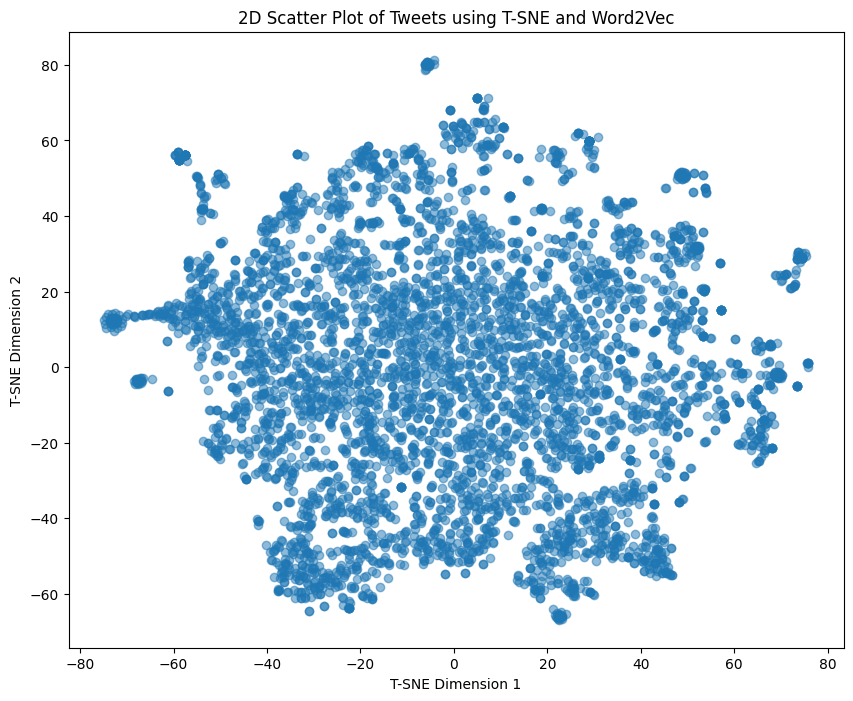

In [42]:
# Make a copy of filtered_tw and tokenize each tweet

token_filtered_tw = filtered_tw.copy()
token_filtered_tw["Content"] = token_filtered_tw["Content"].apply(lambda x: x.split() if isinstance(x, str) else [])

# Step 1: Train the Word2Vec model
model = Word2Vec(token_filtered_tw["Content"].tolist(), vector_size=100, window=5, min_count=1, workers=4)

# Step 2 & 3: Compute average word vectors for each tweet
def tweet_to_vec(tweet):
    if isinstance(tweet, list) and tweet:
        word_vecs = [model.wv[word] for word in tweet if word in model.wv]
        if word_vecs:
            return np.mean(word_vecs, axis=0)
    return np.zeros(model.vector_size)

tweet_vectors = np.array([tweet_to_vec(tweet) for tweet in token_filtered_tw["Content"]])

# Step 4: Apply T-SNE to a fraction of the tweets because it is too computationally expensive for 48k
tsne = TSNE(n_components=2, random_state=0)
sampled_tweet_vectors = tweet_vectors[np.random.choice(len(tweet_vectors), 5000, replace=False)]
tweet_embeddings_2d = tsne.fit_transform(sampled_tweet_vectors)

# Step 5: Plot
plt.figure(figsize=(10, 8))
plt.scatter(tweet_embeddings_2d[:, 0], tweet_embeddings_2d[:, 1], alpha=0.5)
plt.xlabel("T-SNE Dimension 1")
plt.ylabel("T-SNE Dimension 2")
plt.title("2D Scatter Plot of Tweets using T-SNE and Word2Vec")
plt.show()
